# Image Classifier

In [1]:
%pip install -Uqq duckduckgo_search

import fastai
from duckduckgo_search import ddg_images
from fastcore import foundation as fd

Note: you may need to restart the kernel to use updated packages.


I was a bit confused on this L thing, heres what I learned:
L creates an object like a list in python but it has more functionality.

In [2]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return fd.L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('magnolia tree')
urls[0]

Searching for 'magnolia tree'


'https://4.bp.blogspot.com/-BpE-Rp_68R0/Tcg_3OcyHbI/AAAAAAAAAEg/ptwumCFAkvQ/s1600/Magnolia+1r+copy.jpg'

In [4]:
from fastai.vision import all as vis

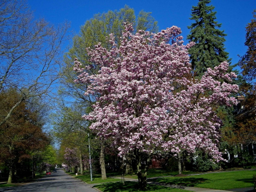

In [5]:
from fastdownload import download_url
dest = 'magnolia.jpg'
download_url(urls[0], dest, show_progress=False)

im = vis.Image.open(dest)
im.to_thumb(256, 256)

Searching for 'cyprus tree'


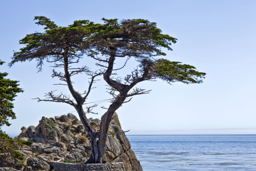

In [6]:
download_url(search_images('cyprus tree', max_images=1)[0], 'cyprus.jpg', show_progress=False)
vis.Image.open('cyprus.jpg').to_thumb(256, 256)

In [7]:
searches = 'magnolia tree', 'cyprus tree'
path = vis.Path('magnolia_or_not')
from time import sleep

for o in searches:
  dest = (path/o) # dest will become magnolia_or_not/magnolia or magnolia_or_not/cyprus
  dest.mkdir(exist_ok=True, parents=True) # make the directory if it doesn't exist, not sure what parents does
  vis.download_images(dest, urls=search_images(f'{o} photo'))
  sleep(10)
  vis.download_images(dest, urls=search_images(f'{o} sun photo'))
  sleep(10)
  vis.download_images(dest, urls=search_images(f'{o} shade photo'))
  vis.resize_images(dest, max_size=400, dest=dest)

Searching for 'magnolia tree photo'
Searching for 'magnolia tree sun photo'
Searching for 'magnolia tree shade photo'
Searching for 'cyprus tree photo'
Searching for 'cyprus tree sun photo'
Searching for 'cyprus tree shade photo'


In [8]:
path

Path('magnolia_or_not')

In [9]:
image_files = vis.get_image_files(path)
image_files

(#342) [Path('magnolia_or_not/magnolia tree/a571f98c-2da0-464c-b666-d04075fa6f6a.jpg'),Path('magnolia_or_not/magnolia tree/3735125d-5b03-4e4e-80ab-76a06337ca66.JPG'),Path('magnolia_or_not/magnolia tree/6407296a-453a-4cc0-ab4b-234c4e12e282.jpg'),Path('magnolia_or_not/magnolia tree/9b24bbe4-ba69-45e2-b2e6-5ebe39bfb5a6.jpg'),Path('magnolia_or_not/magnolia tree/9b28823e-b69b-4c7b-96f6-168a312315a1.jpeg'),Path('magnolia_or_not/magnolia tree/7a0bf611-0090-4fa7-995f-12f8411847a9.jpg'),Path('magnolia_or_not/magnolia tree/ef09f4dd-c75c-4435-927a-4e24978a1d75.jpg'),Path('magnolia_or_not/magnolia tree/cda58ac6-9ba6-4f16-896c-9092c4f0fdf7.jpg'),Path('magnolia_or_not/magnolia tree/02849d41-a7a7-4809-92d6-704a11f49464.jpg'),Path('magnolia_or_not/magnolia tree/3e12f943-84a9-49d2-9174-1460ba6e4487.jpg')...]

In [10]:
failed = vis.verify_images(image_files)
failed

(#0) []

In [11]:
failed.map(fd.Path.unlink)

(#0) []

Creating a DataLoaders:
A data loader consists of a Training set and a Validation set

This is easy with FastAi. we use the DataBlock

In [12]:
import fastai.data as data

Here is how the code works for getting the parent label

In [17]:
label = vis.parent_label(image_files[200])
label

'cyprus tree'

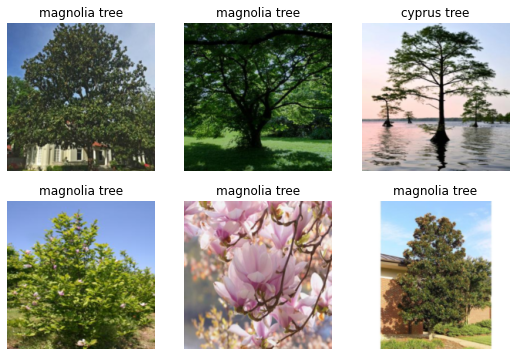

In [13]:
dls = data.block.DataBlock(
    blocks=(vis.ImageBlock, vis.CategoryBlock),
    get_items=vis.get_image_files,
    splitter=vis.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=vis.parent_label,
    item_tfms=vis.Resize(192, method='squish')
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

blocks=(ImageBlock, CategoryBlock)
The inputs to our models are images and the outputs are categories

get_items=get_image_files
To get the inputs run that function which returns a list of all the image files in a path

splitter
Split the data into a training and validation set randomly using 20% of the data for validation

get_y
Gets the name of the parent of each file

item_tfms
Transforms each item before training by squishing it

In [18]:
import torchvision.models as models

In [20]:
learn = vis.vision_learner(dls, models.resnet18, metrics=vis.error_rate)
learn.fine_tune(3) # the 3 is the number of epochs

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time


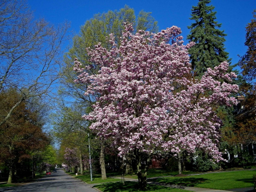

In [23]:
im = vis.Image.open('magnolia.jpg')
im.to_thumb(256, 256)

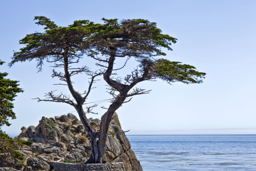

In [24]:
im = vis.Image.open('cyprus.jpg')
im.to_thumb(256, 256)

In [26]:
is_magnolia, _, probs = learn.predict(vis.PILImage.create('magnolia.jpg'))
print(f"This is a: {is_magnolia}.")
print(f"Probability it's a cyprus tree: {probs[0]:.4f}")

This is a: magnolia tree.
Probability it's a cyprus tree: 0.0000


In [28]:
is_magnolia, _, probs = learn.predict(vis.PILImage.create('cyprus.jpg'))
print(f"This is a: {is_magnolia}.")
print(f"Probability it's a cyprus tree: {probs[0]:.4f}")

This is a: cyprus tree.
Probability it's a cyprus tree: 0.9999
